In [1]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [27]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)
        
        
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = np.zeros((self.image_size, self.image_size, 1))
        
        
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)
            
        
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [38]:
image_size = 128
train_path = "stage1_train/"
epochs = 10
batch_size = 8


train_ids = next(os.walk(train_path))[1]

val_data_size = 10

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [39]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x,y)
print(np.shape(x))
print(np.shape(y))

(array([[[[0.90980392, 0.90980392, 0.90980392],
         [0.90196078, 0.90196078, 0.90196078],
         [0.90588235, 0.90588235, 0.90588235],
         ...,
         [0.89803922, 0.89803922, 0.89803922],
         [0.89803922, 0.89803922, 0.89803922],
         [0.91372549, 0.91372549, 0.91372549]],

        [[0.89803922, 0.89803922, 0.89803922],
         [0.90980392, 0.90980392, 0.90980392],
         [0.89803922, 0.89803922, 0.89803922],
         ...,
         [0.89411765, 0.89411765, 0.89411765],
         [0.90196078, 0.90196078, 0.90196078],
         [0.90196078, 0.90196078, 0.90196078]],

        [[0.90588235, 0.90588235, 0.90588235],
         [0.89411765, 0.89411765, 0.89411765],
         [0.90588235, 0.90588235, 0.90588235],
         ...,
         [0.90196078, 0.90196078, 0.90196078],
         [0.90196078, 0.90196078, 0.90196078],
         [0.89411765, 0.89411765, 0.89411765]],

        ...,

        [[0.91372549, 0.91372549, 0.91372549],
         [0.91764706, 0.91764706, 0.91764706

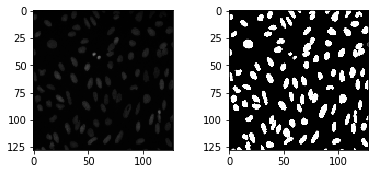

In [40]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1,2,1)
ax.imshow(x[r])
ax = fig.add_subplot(1,2,2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [41]:
def down_block(x, filters, kernel_size=(3,3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = tf.keras.layers.MaxPool2D((2,2), (2,2))(c)
    
    return c,p

In [42]:
def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = tf.keras.layers.UpSampling2D((2,2))(x)
    concat = tf.keras.layers.Concatenate()([us, skip])
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [43]:
def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [47]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = tf.keras.layers.Input((image_size, image_size, 3))
    
    p0=inputs
    c1, p1 = down_block(p0, f[0])
    c2, p2 = down_block(p1, f[1])
    c3, p3 = down_block(p2, f[2])
    c4, p4 = down_block(p3, f[3])
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3])
    u2 = up_block(u1, c3, f[2])
    u3 = up_block(u2, c2, f[1])
    u4 = up_block(u3, c1, f[0])
    
    outputs = tf.keras.layers.Conv2D(1, (1,1), padding="same", activation="sigmoid")(u4)
    model = tf.keras.models.Model(inputs, outputs)
    return model

In [48]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 128, 128, 16) 448         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_57[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 64, 64, 16)   0           conv2d_58[0][0]                  
____________________________________________________________________________________________

In [49]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

Epoch 1/10
82/82 [==============================] - 90s 1s/step - loss: 0.4703 - acc: 0.8374 - val_loss: 0.3283 - val_acc: 0.8467
Epoch 2/10
82/82 [==============================] - 51s 622ms/step - loss: 0.2181 - acc: 0.8829 - val_loss: 0.1618 - val_acc: 0.8999
Epoch 3/10
82/82 [==============================] - 55s 674ms/step - loss: 0.1689 - acc: 0.9151 - val_loss: 0.1429 - val_acc: 0.9092
Epoch 4/10
82/82 [==============================] - 54s 660ms/step - loss: 0.1272 - acc: 0.9356 - val_loss: 0.1361 - val_acc: 0.9148
Epoch 5/10
82/82 [==============================] - 53s 651ms/step - loss: 0.1132 - acc: 0.9401 - val_loss: 0.0959 - val_acc: 0.9360
Epoch 6/10
82/82 [==============================] - 53s 650ms/step - loss: 0.0961 - acc: 0.9468 - val_loss: 0.0965 - val_acc: 0.9361
Epoch 7/10
82/82 [==============================] - 53s 650ms/step - loss: 0.0986 - acc: 0.9462 - val_loss: 0.1034 - val_acc: 0.9348
Epoch 8/10
82/82 [==============================] - 56s 684ms/step - los

In [50]:
model.save_weights("Result_Weight.h5")

x, y = valid_gen.__getitem__(1)
result = model.predict(x)

result = result > 0.5

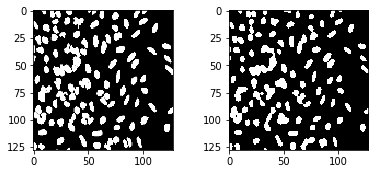

In [51]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")